## Import packages

In [71]:
# Import necessary libraries
import yfinance as yf
import pandas as pd
import numpy as np
from itertools import product
import matplotlib.pyplot as plt

## Gathering tickers from our filtered stocks

In [2]:
# Read the CSV file into a Pandas DataFrame
df = pd.read_csv("filtered_stock.csv")

# Set the 'Key' column as the index of the DataFrame
df = df.set_index('Key')

# Extract tickers for the 'tech' category from the 'Values' column
tickers = df.loc[['tech'], 'Values'].to_list()

# Split the tickers string into a list of individual tickers
tickers = tickers[0].split(', ')

## Parameters

In [28]:
# Number of days for short-term calculations
short_period = 5  

# Number of days for long-term calculations
long_period = 15  

# Thresholds for Relative Strength Index (RSI)
rsi_high = 70
rsi_low = 30

# Number of features (adjust according to your strategy)
features = 6  

# Initial portfolio size in dollars
portfoliosize = 100000  

# Amount of risk per trade (used for Average True Range - ATR - to determine position sizing)
positionrisk = 0.02  

# Risk free rate
positionrisk = 0.03 

# Number of trading days AMEND FOR TIME
periods = 252

## Creating technical functions

In [4]:
# Function to calculate Average True Range (ATR)
def atr(ticker):
    prev_close = ticker['Close'].shift(1)
    tr = np.maximum((ticker['High'] - ticker['Low']),
                    np.maximum(abs(ticker['High'] - prev_close),
                               abs(prev_close - ticker['Low'])))
    atr = tr.ewm(span=short_period, adjust=False).mean()
    ticker['ATR (Position)'] = portfoliosize * positionrisk / atr

# Function to calculate Bollinger Bands
def bollinger_band(ticker):
    upper_band = ticker['Close'].rolling(window=long_period).mean() + 2 * ticker['Close'].rolling(window=long_period).std()
    lower_band = ticker['Close'].rolling(window=long_period).mean() - 2 * ticker['Close'].rolling(window=long_period).std()

    # Set 'Bollinger Band' based on conditions
    ticker['Bollinger Band'] = 0
    ticker.loc[ticker['Close'] <= lower_band, 'Bollinger Band'] = 1
    ticker.loc[ticker['Close'] >= upper_band, 'Bollinger Band'] = -1

# Function to calculate Moving Average Convergence Divergence (MACD)
def macd(ticker):
    shortema = ticker['Close'].transform(lambda x: x.ewm(span=short_period, adjust=False).mean())
    longema = ticker['Close'].transform(lambda x: x.ewm(span=long_period, adjust=False).mean())

    # Set 'MACD' based on conditions
    ticker['MACD'] = -1
    ticker.loc[shortema >= longema, 'MACD'] = 1

# Function to calculate Relative Strength Index (RSI)
def rsi(ticker):
    diff = ticker['Close'].transform(lambda x: x.diff())
    up = diff.where(diff > 0, 0).rolling(window=short_period).mean()
    down = -diff.where(diff < 0, 0).rolling(window=short_period).mean()
    rs = up / down
    rsi = 100 - (100 / (1 + rs))

    ticker['RSI'] = 0
    ticker.loc[rsi > rsi_high, 'RSI'] = -1
    ticker.loc[rsi < rsi_low, 'RSI'] = 1

# Function to calculate Stochastic Oscillators
def stochastic_oscillators(ticker):
    low = ticker['Low'].transform(lambda x: x.rolling(window=short_period).min())
    high = ticker['High'].transform(lambda x: x.rolling(window=short_period).max())
    stochastic = ((ticker['Close'] - low) / (high - low)) * 100
    stockasticoscillator = stochastic.rolling(window=short_period).mean()

    ticker['Stochastic Oscillator'] = 0
    ticker.loc[stockasticoscillator > 80, 'Stochastic Oscillator'] = -1
    ticker.loc[stockasticoscillator < 20, 'Stochastic Oscillator'] = 1

# Function to calculate Moving Average Crossover
def ma_crossover(ticker):
    sma_20 = ticker['Close'].rolling(window=20).mean()
    sma_50 = ticker['Close'].rolling(window=50).mean()
    ema_12 = ticker['Close'].ewm(span=12, adjust=False).mean()
    ema_26 = ticker['Close'].ewm(span=26, adjust=False).mean()

    # Create signals based on crossovers
    sma_buy_signal = (sma_20 > sma_50) & (sma_20.shift(1) <= sma_50.shift(1))
    sma_sell_signal = (sma_20 < sma_50) & (sma_20.shift(1) >= sma_50.shift(1))

    ema_buy_signal = (ema_12 > ema_26) & (ema_12.shift(1) <= ema_26.shift(1))
    ema_sell_signal = (ema_12 < ema_26) & (ema_12.shift(1) >= ema_26.shift(1))

    buy_signal = sma_buy_signal | ema_buy_signal
    sell_signal = sma_sell_signal | ema_sell_signal

    ticker['Moving Average'] = 0
    ticker.loc[buy_signal, 'Moving Average'] = -1
    ticker.loc[sell_signal, 'Moving Average'] = 1

# Function to calculate Parabolic SAR
def calculate_parabolic_sar(ticker, acceleration=0.02, maximum=0.2):
    sar_values = []
    af = acceleration

    # Initial SAR is set to the first high or low price
    sar_values.append(ticker.iloc[0]['High'] if ticker.iloc[0]['High'] > ticker.iloc[0]['Low'] else ticker.iloc[0]['Low'])

    # Iterate through the DataFrame
    for i in range(1, len(ticker)):
        # Calculate the Extreme Point (EP)
        ep = ticker.iloc[i - 1]['High'] if sar_values[-1] < ticker.iloc[i - 1]['Low'] else ticker.iloc[i - 1]['Low']

        # Update SAR based on the formula
        sar_value = sar_values[-1] + af * (ep - sar_values[-1])

        # Limit the acceleration factor to the maximum value
        af = min(af + acceleration, maximum)

        # Append the SAR value to the list
        sar_values.append(sar_value)

    ticker['Parabolic SAR'] = 0
    ticker.loc[sar_values > ticker['Close'], 'Parabolic SAR'] = -1
    ticker.loc[sar_values < ticker['Close'], 'Parabolic SAR'] = 1

## Applying indicators to each stock

In [5]:
#condition_all_ones = (df['Bollinger Band'] == 1) & (df['B'] == 1) & (df['C'] == 1)

for ticker in tickers:
    stock_data = yf.download(ticker)
    globals()['%s' % ticker] = stock_data
    globals()['%s' % ticker]['Returns'] = (stock_data['Close'].pct_change()).to_frame()
    
    
    #apply indicator functions
    
    atr(globals()['%s' % ticker])
    
    bollinger_band(globals()['%s' % ticker])
    macd(globals()['%s' % ticker])
    rsi(globals()['%s' % ticker])
    stochastic_oscillators(globals()['%s' % ticker])
    ma_crossover(globals()['%s' % ticker])
    calculate_parabolic_sar(globals()['%s' % ticker])
    
    
    
    
    globals()['%s' % ticker] = globals()['%s' % ticker].dropna()
    indicators = globals()['%s' % ticker].columns[8:].tolist()

print("\nAll tickers processed.")



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [6]:
AUDC.head(50)

,Open,High,Low,Close,Adj Close,Volume,Returns,ATR (Position),Bollinger Band,MACD,RSI,Stochastic Oscillator,Moving Average,Parabolic SAR
Date,,,,,,,,,,,,,,
1999-06-01,8.625000,8.68750,7.56250,8.00000,7.259977,1467600,-0.062271,2666.666667,0,-1,0,0,1,-1
1999-06-02,8.000000,8.06250,7.56250,7.78125,7.061462,588400,-0.027344,3272.727273,0,-1,0,0,0,-1
1999-06-03,7.937500,8.59375,7.68750,8.46875,7.685366,744400,0.088353,3285.171103,0,-1,0,0,0,-1
1999-06-04,8.500000,8.81250,8.37500,8.37500,7.600288,653400,-0.011070,3975.460123,0,-1,0,0,0,-1
1999-06-07,8.625000,8.62500,8.31250,8.62500,7.827163,879800,0.029851,4940.279543,0,-1,0,0,0,-1
1999-06-08,8.500000,8.71875,8.50000,8.62500,7.827163,283600,0.000000,6279.407806,0,1,-1,0,0,-1
1999-06-09,8.750000,8.87500,8.68750,8.75000,7.940598,535400,0.014493,7465.756347,0,1,-1,0,-1,-1
1999-06-10,8.812500,8.81250,8.34375,8.68750,7.883882,637000,-0.007143,7073.139507,0,1,-1,0,0,-1
1999-06-11,8.562500,8.68750,8.43750,8.56250,7.770442,410600,-0.014388,8194.634540,0,1,0,0,0,-1


In [48]:
summary = pd.DataFrame()
for indicator in indicators:
    summary.loc["", indicator] = 0

for ticker in tickers:
    globals()['%s_summary' % ticker] = pd.DataFrame()
    CAGR = np.exp((globals()['%s' % ticker]['Returns']).mean() * periods) - 1
    for indicator in indicators:
        globals()['%s_summary' % ticker].loc["", indicator] = (np.exp((globals()['%s' % ticker]['Returns']*(globals()['%s' % ticker][indicator].shift(1))).mean() * periods) - 1)-CAGR
    summary += globals()['%s_summary' % ticker]

summary = summary / len(tickers)
weightings = summary[summary > 0] / float(summary[summary > 0].sum(axis = 1))

In [55]:
# Create an empty DataFrame to store the summary
summary = pd.DataFrame()

# Loop through each indicator and initialize the summary DataFrame with zeros
for indicator in indicators:
    summary.loc["", indicator] = 0
    signals.loc["", indicator] = 0

# Loop through each ticker
for ticker in tickers:
    # Create a new DataFrame for each ticker
    ticker_summary = pd.DataFrame()

    # Calculate Compound Annual Growth Rate (CAGR) for the ticker's returns
    CAGR = np.exp((globals()['%s' % ticker]['Returns']).mean() * periods) - 1

    # Loop through each indicator
    for indicator in indicators:
        # Calculate the indicator contribution to the summary, considering previous values
        indicator_contribution = (np.exp((globals()['%s' % ticker]['Returns'] * (globals()['%s' % ticker][indicator].shift(1))).mean() * periods) - 1) - CAGR

        # Assign the calculated value to the ticker's summary DataFrame
        ticker_summary.loc["", indicator] = indicator_contribution

    # Add the ticker's summary to the overall summary
    summary += ticker_summary

# Calculate the average summary values across all tickers
summary = summary / len(tickers)

# Calculate weightings for indicators where values are greater than 0
positive_summary = summary[summary > 0]
weightings = positive_summary / float(positive_summary.sum(axis=1))


In [70]:
AUDC_summary

,Bollinger Band,MACD,RSI,Stochastic Oscillator,Moving Average,Parabolic SAR
,-0.332299,0.08281,-0.461565,-0.272609,-0.264609,0.329205


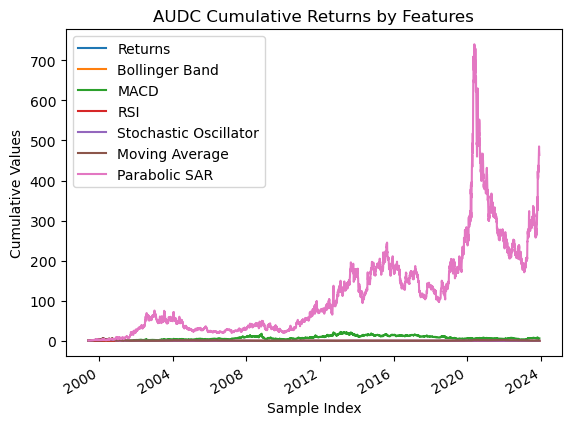

In [130]:
# Assuming AUDC is your DataFrame

# Select multiplier columns
multiplier_columns = AUDC.iloc[:, 8:]
multiplier_columns[multiplier_columns == 0] = 1

# Multiply multiplier columns by 'Returns'
result_columns = multiplier_columns.fillna(1).shift(1).multiply(AUDC['Returns'], axis=0)

# Calculate cumulative returns for each column
cumulative_returns = (result_columns+1).cumprod()

# Combine the results with the original 'Returns' column
result_df = pd.concat([AUDC['Returns'], cumulative_returns], axis=1)

# Plot the cumulative returns as a line graph
result_df.plot(kind='line')
plt.title('AUDC Cumulative Returns by Features')
plt.xlabel('Sample Index')
plt.ylabel('Cumulative Values')
plt.legend(result_df.columns)  # Show legend with column names
plt.show()


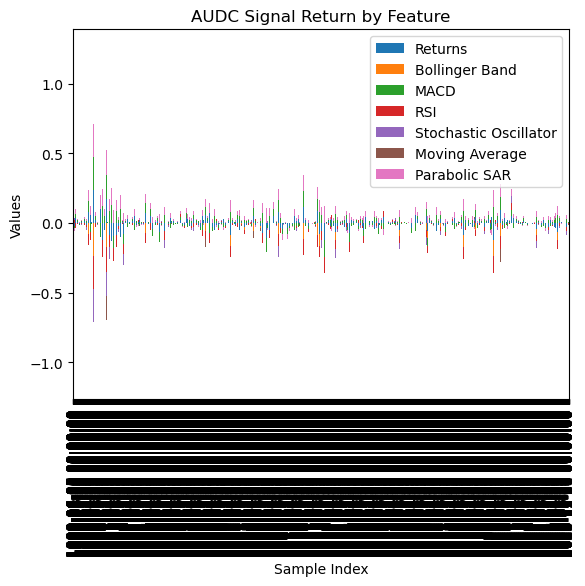

In [129]:
multiplier_columns = AUDC.iloc[:, 8:]
result_columns = multiplier_columns.multiply(AUDC['Returns'], axis=0)

# Combine the results with the original 'returns' column
result_df = pd.concat([AUDC['Returns'], result_columns], axis=1)

# Plot the results
result_df.plot(kind='bar', stacked=True)
plt.title('AUDC Signal Return by Feature')
plt.xlabel('Sample Index')
plt.ylabel('Values')
plt.show()

In [54]:
weightings # weightings of all mid-cap tech stocks

,Bollinger Band,MACD,RSI,Stochastic Oscillator,Moving Average,Parabolic SAR
,NaN,NaN,NaN,NaN,NaN,NaN


In [128]:
AUDC_weightings # weightings of AUDC

,Bollinger Band,MACD,RSI,Stochastic Oscillator,Moving Average,Parabolic SAR
,NaN,0.200987,NaN,NaN,NaN,0.799013


In [69]:
for ticker in tickers:
    for indicators in indicators:
        globals()['%s' % ticker][indicator] = globals()['%s' % ticker][indicators] * weightings[indicators]
    signal = round(globals()['%s' % ticker].iloc[:,8:].sum(axis = 1))
    globals()['%s' % ticker]["Signal"] = signal
    

KeyError: 'P'